In [1]:
.libPaths('/home/garret/anaconda3/envs/Mon/lib/R/library')
.libPaths()

[1] "/home/garret/anaconda3/envs/Mon/lib/R/library"
[2] "/home/garret/anaconda3/envs/HR/lib/R/library"

In [2]:
packageVersion("monocle3")
rm(list = ls())  # Clear the environment
options(warn=-1) # Turn off warning message globally
library("monocle3") # Load Monocle
library("Biobase")
library("Seurat")
library("ggplot2")
library("xlsx")
library("scales")

[1] ‘0.2.3.0’

Loading required package: Biobase

Loading required package: BiocGenerics

Loading required package: parallel


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which.min


Welcome to Bioconductor

    Vignettes contain introductory material; vie


# subsetting cells and genes

In [3]:
bcc.integrated<-readRDS(file =  "/media/garret/New Volume/scRNAseq_data/Personalis/Tcell/bcc.integrated.rds")
DefaultAssay(bcc.integrated) <- "RNA"

new.ident <- c("Memory_Tcell","Naive_Tcell1","Th17cell","Treg1","Activated_Tcell1",
               "TFH","Activated_Tcell2","Activated_exhausted_Tcell","Effector_memory_Tcell","Treg2",
               "Exhausted_Tcell","Naive_Tcell2")
names(x = new.ident) <- levels(x =bcc.integrated)
bcc.integrated<- RenameIdents(object =bcc.integrated, new.ident)
for (i in 1:length(new.ident)){
assign(paste(new.ident[i],"_barcode",sep=""),colnames(bcc.integrated@assays$RNA@data[,which(Idents(object=bcc.integrated) %in% new.ident[i])]))# this gives all barcodes in cluster
}

CD8_subset<-c(Naive_Tcell1_barcode,Naive_Tcell2_barcode,Activated_Tcell1_barcode,Activated_Tcell2_barcode,Activated_exhausted_Tcell_barcode,Exhausted_Tcell_barcode)
CD8.integrated<-subset(bcc.integrated,cells=CD8_subset)

In [4]:
celltype<-vector()
conditiontype<-vector()
for (i in 1:dim(CD8.integrated@meta.data)[1]){
    celltype[i]<-new.ident[as.numeric(CD8.integrated@meta.data$integrated_snn_res.0.6[i])]
}
CD8.integrated@meta.data$celltype<-celltype

# make monocle object

In [14]:
merge_all_m <-new_cell_data_set(as.matrix(CD8.integrated@assays$RNA@counts), cell_metadata =CD8.integrated@meta.data)
merge_all_m  <- preprocess_cds(merge_all_m ,  num_dim =8)
merge_all_m <- reduce_dimension(merge_all_m,reduction_method = "UMAP",preprocess_method = 'PCA')

In [15]:
merge_all_m  <- cluster_cells(merge_all_m )

In [16]:
merge_all_m <- learn_graph(merge_all_m,use_partition = FALSE)


  |======================================================================| 100%


In [17]:
cell_type_color <- c('Naive_Tcell1'= "#697A21",'Naive_Tcell2'= "#697A21","Activated_exhausted_Tcell"="#88A0B4","Activated_Tcell1" ="darkred","Activated_Tcell2" ="darkred","Exhausted_Tcell"="darkblue")

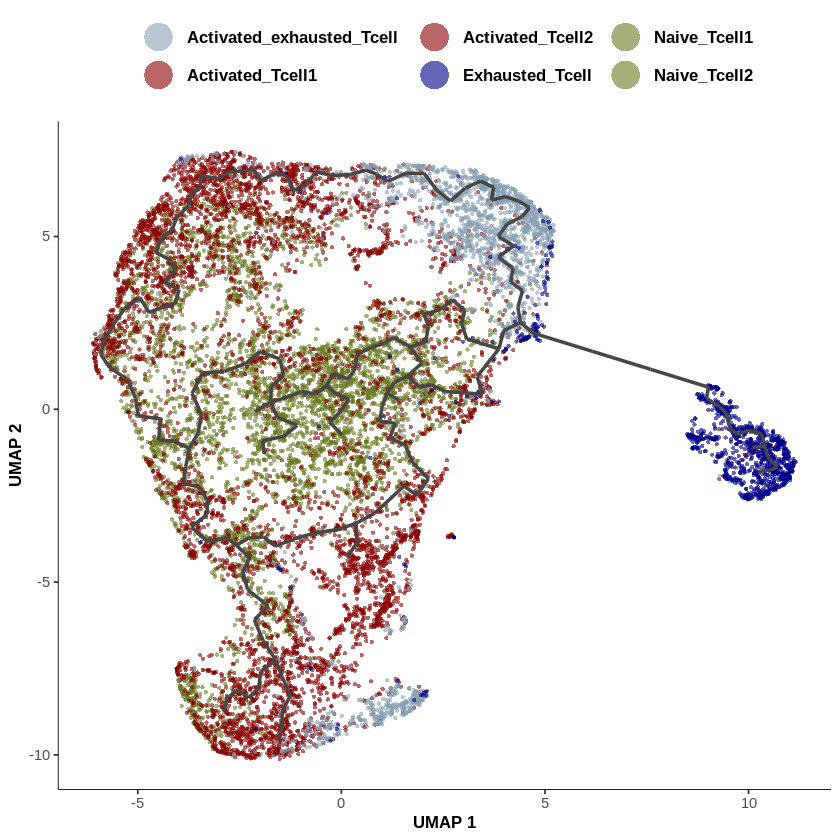

In [18]:
plot_cells(merge_all_m,
           color_cells_by = "celltype",cell_size =1.2,alpha = 0.6,label_cell_groups = FALSE,trajectory_graph_segment_size = 1,label_roots = FALSE,
           label_leaves=FALSE,cell_stroke = I(0/2),
           label_branch_points=FALSE)+
                     scale_color_manual(values = cell_type_color)+ guides(colour = guide_legend(override.aes = list(size=8)))+theme(title=element_text(size=10,angle=0,face="bold"),strip.text = element_text(size = 10,face="bold")
    ,legend.title=element_blank(), legend.text=element_text(size = 10,face="bold") ,legend.position ="top")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Personalis/Tcell/Trajectory_celltype_subset.pdf",width=9,height=10)

In [19]:
get_earliest_principal_node <- function(merge_all_m, celltype="Naive_Tcell1"){
  cell_ids <- which(colData(merge_all_m)[, "celltype"] == celltype)
  
  closest_vertex <-
  merge_all_m@principal_graph_aux[["UMAP"]]$pr_graph_cell_proj_closest_vertex
  closest_vertex <- as.matrix(closest_vertex[colnames(merge_all_m), ])
  root_pr_nodes <-
  igraph::V(principal_graph(merge_all_m)[["UMAP"]])$name[as.numeric(names
  (which.max(table(closest_vertex[cell_ids,]))))]
  
  root_pr_nodes
}
merge_all_m<- order_cells(merge_all_m, root_pr_nodes=get_earliest_principal_node(merge_all_m))

In [20]:
get_earliest_principal_node(merge_all_m)

[1] "Y_13"

In [21]:
pseudotime<-numeric()
for (i in 1:length(merge_all_m@ principal_graph_aux$UMAP$pseudotime)){
    pseudotime[i]<-merge_all_m@ principal_graph_aux$UMAP$pseudotime[[i]]
}

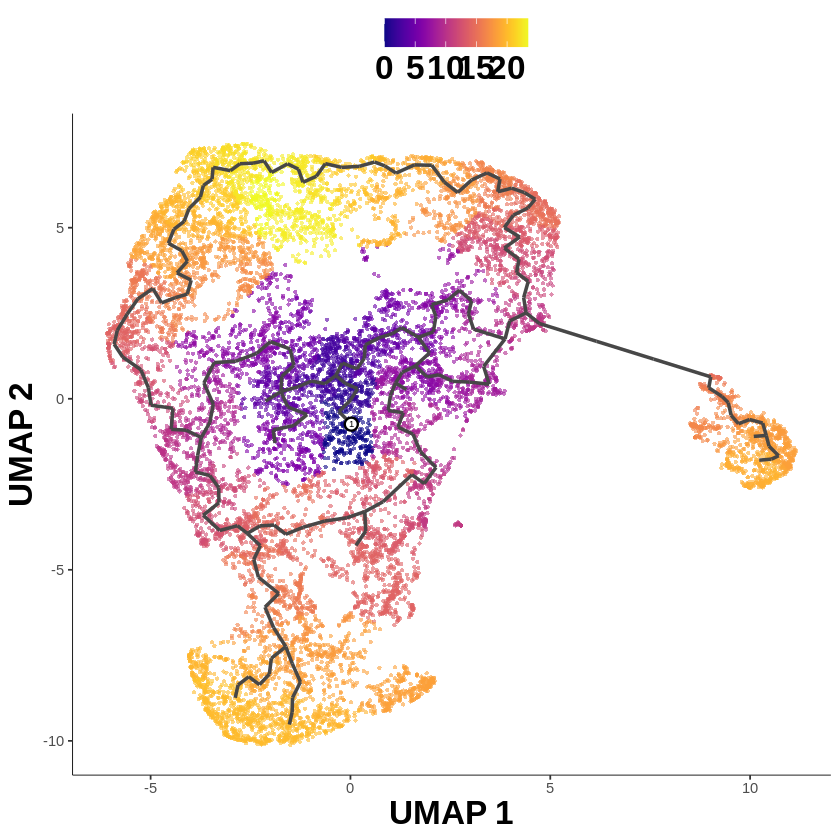

In [22]:
plot_cells(merge_all_m,
           color_cells_by = "pseudotime",cell_size =1.2,alpha = 0.6,label_cell_groups = FALSE,trajectory_graph_segment_size = 1,
           label_leaves=FALSE,cell_stroke = I(0/2),
           label_branch_points=FALSE)+
theme(title=element_text(size=20,angle=0,face="bold"),strip.text = element_text(size = 40,face="bold")
    ,legend.title=element_blank(), legend.text=element_text(size = 20,face="bold") ,legend.position ="top")
ggsave(file="/media/garret/New Volume/scRNAseq_data/Personalis/Tcell/PT_subset.pdf",width=9,height=10)

In [23]:
saveRDS(merge_all_m,file="/media/garret/New Volume/scRNAseq_data/Personalis/Tcell/merge_all_m.rds")

In [35]:
merge_all_m@colData$HAVCR2<-bcc.integrated@assays$RNA@data["HAVCR2",rownames(merge_all_m@colData)]
merge_all_m@colData$IFNG<-bcc.integrated@assays$RNA@data["IFNG",rownames(merge_all_m@colData)]
merge_all_m@colData$CCR7<-bcc.integrated@assays$RNA@data["CCR7",rownames(merge_all_m@colData)]

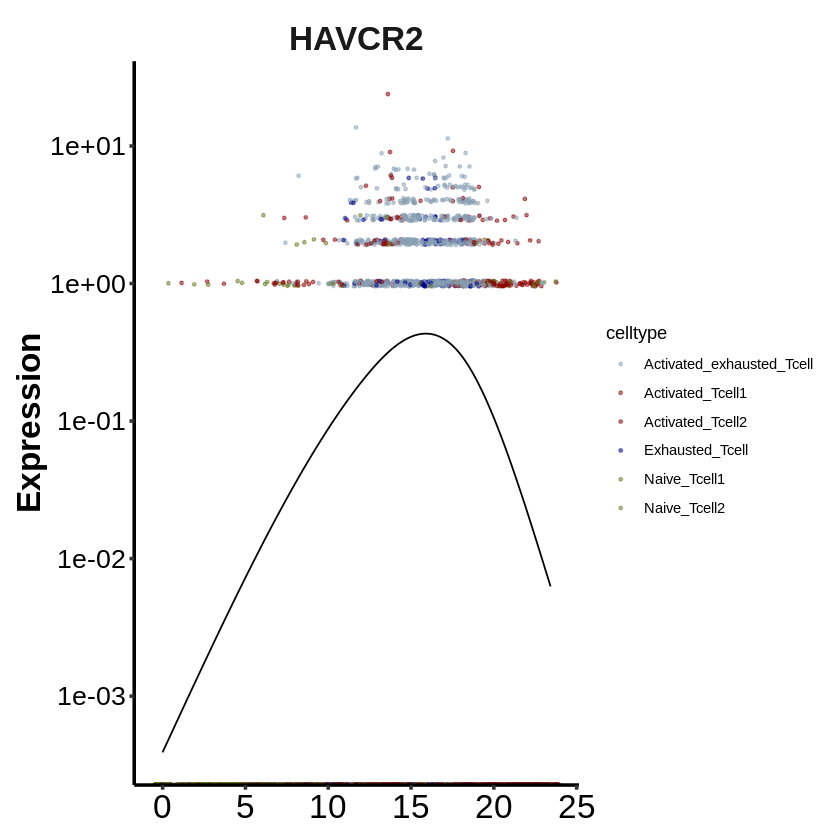

In [29]:
genes <- c("HAVCR2")
mini <- merge_all_m[rowData(merge_all_m)@rownames %in% genes,]
p<-plot_genes_in_pseudotime(mini,label_by_short_name = FALSE,horizontal_jitter=0.5,color_cells_by="celltype", cell_size = 0.7)
p+ #scale_y_continuous(breaks=c(0.5,5))+
theme(strip.text = element_text(size=20, face="bold")) +
scale_color_manual(values =alpha(cell_type_color,0.5))+theme(axis.text.x=element_text(size=20, angle=0,vjust=0.8,hjust = 0.5,colour = "black"),axis.text.y=element_text(size=16, hjust = 1,colour = "black"),axis.title.y=element_text(size=20,face="bold"),axis.title.x=element_blank(),plot.title = element_text(size=50,face="bold"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = 'black', size = 5),axis.ticks.length=unit(.1, "cm"),axis.ticks = element_line(size = 1), plot.margin = margin(10, 10, 10, 10))+
theme(axis.line.x = element_line(size=1, color="black"),axis.line.y = element_line(size=1, color="black")) 
ggsave(file="/media/garret/New Volume/scRNAseq_data/Personalis/Tcell/HAVCR2.pdf",width=10,height=2)

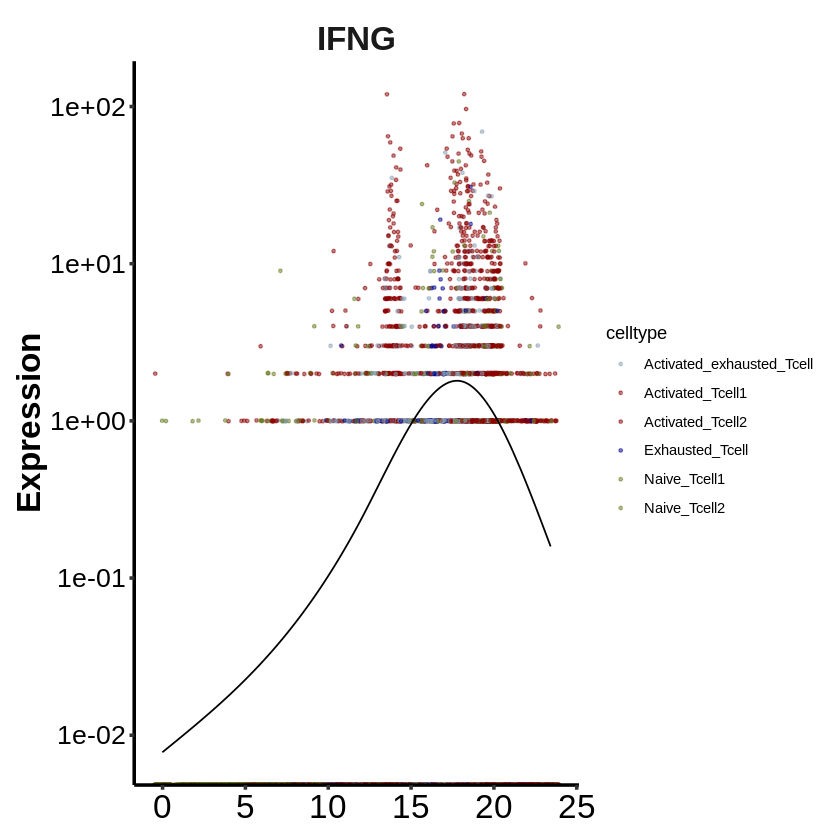

In [30]:
genes <- c("IFNG")
mini <- merge_all_m[rowData(merge_all_m)@rownames %in% genes,]
p<-plot_genes_in_pseudotime(mini,label_by_short_name = FALSE,horizontal_jitter=0.5,color_cells_by="celltype", cell_size = 0.7)
p+ #scale_y_continuous(breaks=c(0.5,5))+
theme(strip.text = element_text(size=20, face="bold")) +
scale_color_manual(values =alpha(cell_type_color,0.5))+theme(axis.text.x=element_text(size=20, angle=0,vjust=0.8,hjust = 0.5,colour = "black"),axis.text.y=element_text(size=16, hjust = 1,colour = "black"),axis.title.y=element_text(size=20,face="bold"),axis.title.x=element_blank(),plot.title = element_text(size=50,face="bold"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = 'black', size = 5),axis.ticks.length=unit(.1, "cm"),axis.ticks = element_line(size = 1), plot.margin = margin(10, 10, 10, 10))+
theme(axis.line.x = element_line(size=1, color="black"),axis.line.y = element_line(size=1, color="black")) 
ggsave(file="/media/garret/New Volume/scRNAseq_data/Personalis/Tcell/IFNG.pdf",width=10,height=2)

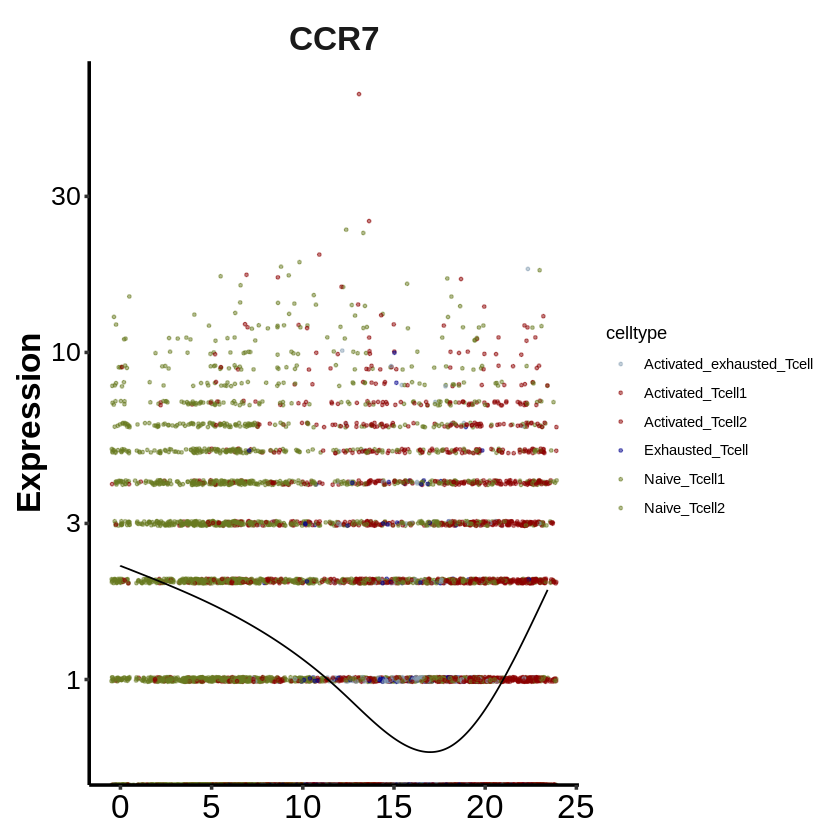

In [57]:
genes <- c("CCR7")
mini <- merge_all_m[rowData(merge_all_m)@rownames %in% genes,]
p<-plot_genes_in_pseudotime(mini,label_by_short_name = FALSE,horizontal_jitter=0.5,color_cells_by="celltype", cell_size = 0.7)
p+ #scale_y_continuous(breaks=c(0.5,5))+
theme(strip.text = element_text(size=20, face="bold")) +
scale_color_manual(values =alpha(cell_type_color,0.5))+theme(axis.text.x=element_text(size=20, angle=0,vjust=0.8,hjust = 0.5,colour = "black"),axis.text.y=element_text(size=16, hjust = 1,colour = "black"),axis.title.y=element_text(size=20,face="bold"),axis.title.x=element_blank(),plot.title = element_text(size=50,face="bold"),panel.grid.major = element_blank(), panel.grid.minor = element_blank(),
panel.background = element_blank(), axis.line = element_line(colour = 'black', size = 5),axis.ticks.length=unit(.1, "cm"),axis.ticks = element_line(size = 1), plot.margin = margin(10, 10, 10, 10))+
theme(axis.line.x = element_line(size=1, color="black"),axis.line.y = element_line(size=1, color="black")) 
ggsave(file="/media/garret/New Volume/scRNAseq_data/Personalis/Tcell/CCR7.pdf",width=10,height=2)